In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download danielerussica/kaggle19v2

In [ ]:
!unzip kaggle19v2.zip
!mkdir processed_data
!mkdir processed_data/predict_aug
!mkdir processed_data/predict
!cd /content
!mv /content/images/images /content/processed_data
!mv /content/kidney_labels/kidney_labels /content/processed_data
!mv /content/tumor_labels/tumor_labels /content/processed_data
!mv /content/test_images/test_images /content/processed_data
!mv /content/combined_labels/combined_labels /content/processed_data

## Define constants:
- We will be working with square 256x256 images
- We need to segment kidneys and tumor

In [1]:
SIZE_X = 256
SIZE_Y = 256
N_CLASSES = 2

In [2]:
import os
import numpy as np
import skimage.io as io
import skimage.transform as trans

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


## Create multi-class U-Net model

In [3]:
def build_unet_model(pretrained_weights = None, img_channel = 1, n_classes = 3):

    inputs = Input((256, 256, img_channel))

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    

    outputs = Conv2D(n_classes, 1, activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = outputs)

    # model.summary()

    if(pretrained_weights):
      model.load_weights(pretrained_weights)

    return model

---
# 2nd attempt unet multi class

In [3]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation (2 times)
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPool2D(2)(f)
   p = Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = concatenate([x, conv_features])
   # dropout
   x = Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [4]:
def build_unet_model(pretrained_weights = None, img_channel = 1, n_classes = 3):
    # inputs
    inputs = Input(shape=(256,256,img_channel))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = Conv2D(n_classes, 1, padding="same", activation = "softmax")(u9)

    unet_model = tf.keras.Model(inputs, outputs)
    # unet_model.summary()

    if(pretrained_weights):
        unet_model.load_weights(pretrained_weights)

   
    return unet_model

## Create Train, Test Generators

### Recap of data
- Imaging data still needs to be normalized [0,1]
- Combined mask has values of 0: background, 1: kidney, 2: tumor


In [5]:
Kidney = [128,128,128]
Tumor = [128,0,0]
Background = [0,0,0]

COLOR_DICT = np.array([Kidney, Tumor, Background])

In [6]:
# helper functions

def get_number(n):
    '''
    returns string 'padded' with correct number of 0s to store input/output data
    '''
    out = "00000"

    out = out[len(str(n)):]
    out += str(n)
    return out

def adjustData(img, mask, is_multi_class, num_class):

    img = img / 255

    if(is_multi_class): 
        
        # multi-class classification
        # will not one-hot, using sparse_categorical_crossentropy instead

        # check if combined mask is correct
        # print(np.unique(mask)) # >> should output [0,1,2]
        # print(mask.shape)
        ##mask_1 = np.expand_dims(mask, axis=2)
        # print(mask_1.shape)
        
        ##mask_2 = to_categorical(mask_1, num_classes=num_class)
        
        # print(mask_2.shape) # 256x256xnum_class

        # plt.imshow(mask_2[:,:,2], cmap='gray')

        ##mask = mask_2        

        # avoid nan loss

        mask = mask.astype('uint8')
        # add small value to all values to avoid 0s
        # mask = mask + 0.001


        # print(mask.dtype)
        # print(np.unique(mask))

    else: # binary classification, kidney/tumor masks still need to be normalized

        mask = mask / 255 
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

    return (img, mask)

def trainGenerator(batch_size, train_path, image_folder, mask_folder, 
                    aug_dict, seed=1, save_to_dir=None, target_size=(SIZE_X,SIZE_Y), 
                    image_color_mode = 'grayscale', mask_color_mode = 'grayscale',
                    image_save_prefix = 'image', mask_save_prefix='mask',
                    multi_class=False, num_class=2):
    
    imageDataGenerator = ImageDataGenerator(**aug_dict)
    maskDataGenerator = ImageDataGenerator(**aug_dict)

    imageGenerator = imageDataGenerator.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed
    )

    maskGenerator = maskDataGenerator.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed
    )

    train_generator = zip(imageGenerator, maskGenerator)

    for (img, mask) in train_generator:
        img, mask = adjustData(img, mask, multi_class, num_class)
        # print('yielded img shape: ', img.shape)
        # print('yielded mask shape: ', mask.shape)
        yield (img, mask)


def testGenerator(test_path, num_pat, num_image = 191,target_size = (256,256),
                  multi_class = False,as_gray = True):
    '''
        Feeds test images to the nn
    '''


    for i in range(num_image):
        name_seg = test_path + '/case_' + get_number(num_pat) + '_im_' + get_number(i) + '.png'

        img = io.imread(name_seg, as_gray = as_gray)
        img = img / 255 # normalize image
        img = trans.resize(img,target_size)     # resize image in order to be able to feed it to the model
        img = np.reshape(img,img.shape+(1,)) if (not multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        
        yield img


def labelVisualize(num_class, color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out #/ 255



def saveResult(save_path,npyfile,num_pat,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]

        img_name = 'case_' + get_number(num_pat) + '_kid_'+ get_number(i) + '_predict.png'

        io.imsave(os.path.join(save_path,img_name),img)
    

## Train the model with data augmentation

In [7]:
os.chdir('..')
os.getcwd()

'd:\\kits19'

In [8]:
data_gen_args = dict(
                    rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [ ]:
# peek data aug results

myGenerator = trainGenerator(20,'processed_data','images','combined_labels', data_gen_args, save_to_dir = "practice_aug", multi_class=True, num_class=2)

#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break
# (20, 256, 256, 1)
# (20, 256, 256, 1)

In [ ]:
myTrainGenerator = trainGenerator(2, 'processed_data', 'images', 'combined_labels', 
                            data_gen_args, multi_class=True, num_class=3)

unet_multiclass = build_unet_model(img_channel = 1, n_classes = 3)
unet_multiclass.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


model_checkpoint = ModelCheckpoint('unet_aug_kits19.hdf5', monitor='loss', verbose=1, save_best_only = False)
history = unet_multiclass.fit(myTrainGenerator, steps_per_epoch=1000, epochs=10, callbacks=[model_checkpoint])

## Test model

Testing model for multi-class segmentation

In [ ]:
testGene = testGenerator("D:\\kits19\\processed_data\\test_images\\case_00168_test_img", multi_class=True, num_pat=168)
test_model = build_unet_model(n_classes=3, img_channel=1)
test_model.load_weights("D:\\kits19\\unet_aug_kits19.hdf5")
results = test_model.predict_generator(testGene,192,verbose=1)
saveResult("predict_aug_13_12",results, num_pat = 168, flag_multi_class=True, num_class=3)

In [12]:
import matplotlib.pyplot as plt

<class 'numpy.ndarray'>
(191, 256, 256, 3)
[0.7817249  0.7831874  0.7835596  ... 0.99999976 0.9999999  1.        ]
[[1.45507464e-03 2.29028919e-05 8.72601013e-05 ... 1.31113600e-04
  1.47241671e-02 3.28715146e-03]
 [8.70863660e-05 1.77336096e-05 1.15321632e-06 ... 9.28996633e-06
  1.61431381e-04 1.35735807e-03]
 [1.40338880e-05 3.31873252e-07 3.86483450e-08 ... 1.98865723e-06
  1.12849906e-04 9.37834411e-05]
 ...
 [8.98953702e-04 3.01051732e-05 1.17353229e-04 ... 4.43868594e-05
  2.73574726e-04 2.08339584e-03]
 [2.47560372e-03 9.97124240e-04 1.58397568e-04 ... 1.65254009e-04
  1.63678557e-03 4.48722672e-03]
 [6.25934377e-02 1.40616419e-02 1.00795347e-02 ... 8.70644930e-04
  1.36975767e-02 1.41369831e-02]]


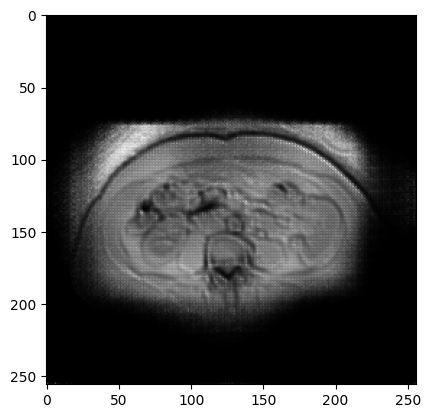

In [13]:
from PIL import Image
print(type(results))
print(results.shape)

print(np.unique(results[95,:,:,0]))
# print(np.unique(results[95,:,:,1]))
# print(np.unique(results[95,:,:,2]))

print(results[95,:,:,1])

plt.imshow(results[95,:,:,1], cmap='gray')


---
